# Notebook 2.5.3 Adding Immunization

---

<br>

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>

---

We implemented the Kermack-McKendrick (KM) model of infectious disease and used it to model the Freshman Plague at Augustana. In this chapter we'll model some interventions intended to reduce the effects of the disease.

<br>

Code from the previous notebook is included in the cell below.

In [1]:
# @title
import pandas as pd
import numpy as np

def change_func(t, state, system):
    s, i, r = state.s, state.i, state.r

    infected = system['C'] * i * s
    recovered = system['R'] * i

    s -= infected
    i += infected - recovered
    r += recovered

    return pd.Series(dict(s=s, i=i, r=r),name="State")

def run_simulation(system, change_func):
    state = pd.Series(dict(s=system['iS'], i=system['iI'], r=system['iR']),
                      name="State Variables")
    frame = pd.DataFrame([],columns=state.index)
    frame.loc[0] = state

    for t in range(0, system['t_end']):
        frame.loc[t+1] = change_func(t, frame.loc[t], system)
    return frame

## Iteration: Adding immunization

Models like this are useful for testing "what if?" scenarios. As an
example, we'll consider the effect of immunization: suppose there is a vaccine that causes a student to become immune to the Freshman Plague without being infected. How might you modify the model to capture this effect?

<br>

One option is to treat immunization as a shortcut from susceptible to
recovered without going through infectious. We can implement this
feature like this:

In [2]:
def add_immunization(system, fraction):
    system['iS'] -= fraction
    system['iR'] += fraction

`add_immunization` moves the given fraction of the population from `S`
to `R`.  As a basis for comparison, we'll run the model with the same parameters as in the previous chapter, with no immunization.

In [3]:
# Make the system
iS = 89; iI = 1; iR = 0
time_c = 3; time_r = 4;
t_end = 14*7
N = iS + iI + iR
system1 = dict(iS=iS/N, iI=iI/N, iR=iR/N, N=N, C = 1/time_c,
              R = 1/time_r, t_end=t_end)

# Run the simulation
results1 = run_simulation(system1, change_func)

Now let's see what happens if 10% of students are immune.
I'll make another system object with the same parameters, then run `add_immunization` to modify the initial conditions.

In [4]:
system2 = dict(iS=iS/N, iI=iI/N, iR=iR/N, N=N, C = 1/time_c,
              R = 1/time_r, t_end=t_end)
add_immunization(system2, 0.1)

Now we can run the simulation like this:

In [5]:
results2 = run_simulation(system2, change_func)

The following figure shows `s` as a function of time, with and
without immunization.

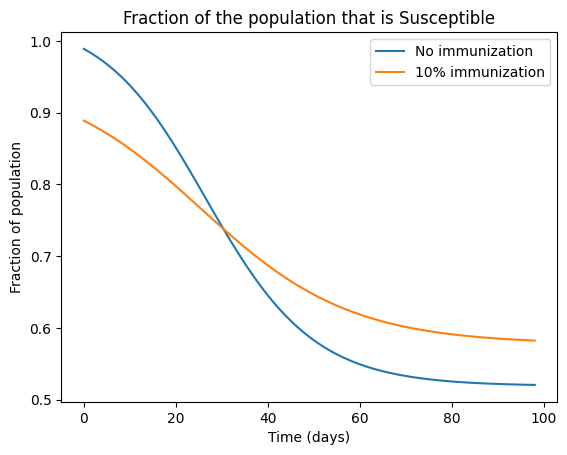

In [6]:
results1.s.plot(label='No immunization', legend=True)
results2.s.plot(label='10% immunization',
                title='Fraction of the population that is Susceptible',
                xlabel='Time (days)',
                ylabel='Fraction of population',legend=True);


With immunization, there is a smaller change in `s`; that is, fewer people are infected.
In the next section we'll compute this change and use it to quantify the effect of immunization.

## Deciding on a metric

When we plot a Series, we get a view of everything that happened
when the model ran, but often we want to boil it down to a few numbers
that summarize the outcome. That is, we want a metric.

<br>

In the KM model, we might want to know the time until the peak of the
outbreak, the number of people who are sick at the peak, the number of
students who will still be sick at the end of the semester, or the total number of students who get sick at any point.

<br>

As an example, we will focus on the last one --- the total number of sick students --- as we consider interventions intended to minimize it. We can get the total number of infections by computing the difference in `s` at the beginning and the end of the simulation.

In [7]:
def calc_total_infected(results, system):
    s_0 = results.s[0]
    s_end = results.s[system['t_end']]
    return s_0 - s_end

And here are the results from the two simulations.

In [8]:
calc_total_infected(results1, system1)

0.468320811028781

In [9]:
calc_total_infected(results2, system2)

0.30650802853979753

Without immunization, almost 47% of the population gets infected at some point. With 10% immunization, only 31% get infected. That's pretty good: notice that an additional 6% of students do not get infected even though they were not actually immunized!

## Sweeping Immunization

Now let's see what happens if we administer more vaccines. This
following function sweeps a range of immunization rates:

In [13]:
def sweep_immunity(system,fraction_array):
    sweep = pd.Series([],dtype=object)

    # Unpack variables from original system and return to argument state
    N = system['N']
    iS, iI, iR = system['iS'], system['iI'],system['iR']
    C, R = system['C'], system['R']
    t_end = system['t_end']

    for fraction in fraction_array:
        system_local = dict(iS=iS, iI=iI, iR=iR, N=N, C = C,
              R = R, t_end=t_end)
        add_immunization(system_local, fraction)
        results = run_simulation(system_local, change_func)
        sweep[fraction] = calc_total_infected(results, system_local)

    return sweep

The parameter of `sweep_immunity` is an array of immunization rates. The result is a `Series` object that maps from each immunization rate to the resulting fraction of students ever infected.

We can call it like this:

In [14]:
fraction_array = np.linspace(0, 1, 21)
infected_sweep = sweep_immunity(system1, fraction_array)

The following figure plots the `Series`. Notice that the $x$-axis is the immunization rate, not time.

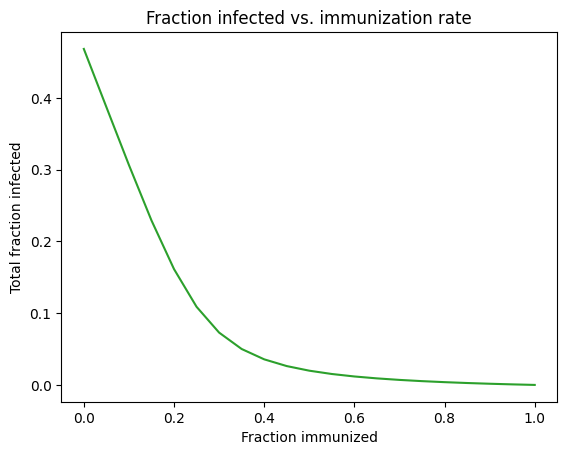

In [15]:
infected_sweep.plot(color='C2',xlabel='Fraction immunized',
         ylabel='Total fraction infected',
         title='Fraction infected vs. immunization rate');

As the immunization rate increases, the number of infections drops
steeply. If 40% of the students are immunized, fewer than 4% get sick.  That's because immunization has two effects: it protects the people who get immunized (of course) but it also protects the rest of the
population.

<br>

Reducing the number of "susceptibles" and increasing the number of
"resistants" makes it harder for the disease to spread, because some
fraction of contacts are wasted on people who cannot be infected. This phenomenon is called *herd immunity*, and it is an important element
of public health.

<br>

The steepness of the curve is a blessing and a curse. It's a blessing
because it means we don't have to immunize everyone, and vaccines can
protect the "herd" even if they are not 100% effective.  But it's a curse because a small decrease in immunization can cause a
big increase in infections. In this example, if we drop from 80%
immunization to 60%, that might not be too bad. But if we drop from 40% to 20%, that would trigger a major outbreak, affecting more than 15% of the population. For a serious disease like measles, just to name one, that would be a public health catastrophe.

---

<br>

## Summary

In general, models are used to predict, explain, and design.
In this notebook, we use an SIR model to predict the effect of immunization and to explain the phenomenon of herd immunity.  In the next notebook, we'll explore the SIR model further by sweeping the parameters.

<br>

---

### Exercise 1

✅ Suppose we have the option to quarantine infected students.  For example, a student who feels ill might be moved to an infirmary or a private dorm room until they are no longer infectious.  How might you incorporate the effect of quarantine in the SIR model?   

<br>

Rather than coding an answer, explain what would be the best approach.  Consider four possibilities:

<br>

1) changing beta based on the number of quarantines

2) changing gamma based on the number of quarantines

3) Moving people from the infected to the recovered groups based on the number of quarantines.

4) Create an new category of students: *q* for quarantined

<br>

Consider which would best represent the reality of the epidemic that you are modeling, as well as what would be the most efficient to code.  Pick two of these possible approaches, describe why each of the two might be the best option, and explain why you think one is better than the other.  Finally, draw a stock-and-flow diagram for your two options

Put your answer in a text cell below, and submit the diagrams to moodle (you can draw them by hand and take a picture if that is easiest; you could also use Lucid charts to do this).